<a href="https://colab.research.google.com/github/kavyajeetbora/ETL_wages/blob/master/WIOD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installation and Import

```python
world_industry_values.to_excel('filename.xlsx')
```

In [45]:
%%time
!wget -q https://dataverse.nl/api/access/datafile/199104 -O wiot.zip
!wget -q https://dataverse.nl/api/access/datafile/199097 -O exchange_rates.xlsx
!wget -q https://dataverse.nl/api/access/datafile/199095 -O sea.xlsx
!wget -q https://dataverse.nl/api/access/datafile/354108 -O NA_data.xlsx
!wget -q https://raw.githubusercontent.com/kavyajeetbora/ETL_wages/master/data/PPP_export.csv -O ppp.csv

CPU times: user 342 ms, sys: 44.3 ms, total: 386 ms
Wall time: 38.5 s


In [46]:
%%time

!pip install -q pyxlsb
import pandas as pd
from zipfile import ZipFile
from tqdm import tqdm
import seaborn as sns
from pyxlsb import open_workbook as open_xlsb

CPU times: user 58.1 ms, sys: 7.19 ms, total: 65.3 ms
Wall time: 5.55 s


## SEA

In [4]:
%%time
sea = pd.read_excel("sea.xlsx", sheet_name='DATA')

CPU times: user 11.1 s, sys: 123 ms, total: 11.2 s
Wall time: 11.3 s


In [5]:
sea.head(3)

,country,variable,description,code,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,AUS,CAP,"Crop and animal production, hunting and relate...",A01,9739.77,13729.03,9726.30,11808.62,11163.98,12429.90,8706.66,11227.29,12556.71,13768.79,18441.27,20106.04,19659.28,18986.06,20525.22
1,AUS,CAP,Forestry and logging,A02,582.69,740.04,540.79,651.96,649.34,676.64,549.27,616.70,716.86,749.91,894.94,923.40,1001.44,1247.96,1206.44
2,AUS,CAP,Fishing and aquaculture,A03,869.31,1122.29,652.69,1024.72,1059.83,923.46,904.15,863.98,1146.37,1108.94,1116.14,1213.94,1182.11,1388.98,1475.22


In [6]:
year_range = list(range(2000,2015))

## Convert to USD $

In [7]:
exchange = pd.read_excel('exchange_rates.xlsx', sheet_name='EXR', header=3)
exchange.columns = list(exchange.columns[:2].str.lower()) + [int(c.replace("_", "")) for c in exchange.columns[2:]]
exchange.loc[exchange['acronym']=='ROM', 'acronym'] = 'ROU'
exchange = pd.melt(exchange, id_vars=['acronym'], value_vars=list(range(2000,2015)), var_name='Year')
exchange.head(3)

,acronym,Year,value
0,AUS,2000,0.582346
1,AUT,2000,0.923600
2,BEL,2000,0.923600


In [8]:
SEA = pd.melt(sea, id_vars=['country','variable','code'], value_vars= year_range, var_name='year')
SEA.head(3)

,country,variable,code,year,value
0,AUS,CAP,A01,2000,9739.77
1,AUS,CAP,A02,2000,582.69
2,AUS,CAP,A03,2000,869.31


In [9]:
SEA_USD = pd.merge(left=SEA,
         right=exchange,
         how='left',
         left_on=SEA['country']+SEA['year'].astype(str),
         right_on=exchange['acronym']+exchange['Year'].astype(str),
         suffixes=('', '_y')
)

SEA_USD['value'] = SEA_USD['value']*SEA_USD['value_y']
SEA_USD = SEA_USD.drop(['key_0', 'value_y', 'acronym', 'Year'], axis=1)

## Unpivot changes
SEA_USD = SEA_USD.pivot(columns=['year'], index=['country','variable', 'code'], values='value').reset_index()
SEA_USD.head(3)

year,country,variable,code,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,AUS,CAP,A01,5671.916100,7106.640173,5290.163749,7697.850440,8223.153224,9494.504536,6559.162311,9414.767530,10739.314578,10895.298602,16956.729324,20753.655548,20363.082224,18386.613128,18528.013468
1,AUS,CAP,A02,339.327191,383.071345,294.137303,425.002293,478.290208,516.847404,413.792554,517.140569,613.105268,593.406783,822.896435,953.142714,1037.291552,1208.558159,1089.047356
2,AUS,CAP,A03,506.239201,580.937706,355.000049,667.998572,780.648522,705.379380,681.141402,724.499933,980.450138,877.508658,1026.289614,1253.041007,1224.429538,1345.125734,1331.673718


## Adjusted USD $

In [10]:
GO_PI = sea.loc[sea['variable']=='GO_PI'].copy()
GO_PI[GO_PI.columns[4:]] = GO_PI[GO_PI.columns[4:]]/100
GO_PI = pd.melt(GO_PI, id_vars=['country','variable', 'code'], value_vars=year_range, var_name='Year')
GO_PI.head(3)

,country,variable,code,Year,value
0,AUS,GO_PI,A01,2000,0.91576
1,AUS,GO_PI,A02,2000,0.91576
2,AUS,GO_PI,A03,2000,0.91576


In [11]:
adj_USD = pd.merge(left=SEA,
         right=GO_PI,
         how='left',
         left_on=SEA['country']+SEA['year'].astype(str)+SEA['code'],
         right_on=GO_PI['country']+GO_PI['Year'].astype(str)+GO_PI['code'],
         suffixes=('', '_y')
)
adj_USD['value'] = adj_USD['value']*adj_USD['value_y']
adj_USD = adj_USD.drop(['key_0', 'country_y','variable_y','code_y', 'Year', 'value_y'], axis=1)

## Unpivot changes
adj_USD = adj_USD.pivot(columns=['year'], index=['country','variable', 'code'], values='value').reset_index()
adj_USD.sample(4)

year,country,variable,code,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
20387,IRL,LAB,B,172.935831,248.853492,210.745778,216.833652,169.789604,203.69641,394.294014,586.947514,489.114785,529.846592,320.21,466.45341,577.285197,263.503684,281.028171
13628,FRA,EMPE,C30,77.020440,78.326640,78.911880,73.844800,70.019180,73.04340,76.366800,80.243560,82.011480,77.868180,76.00,75.10926,80.719080,82.344000,81.427670
15847,GRC,II_QI,U,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.00,100.00000,100.000000,100.000000,100.000000
10594,DNK,VA,C20,7677.697390,8181.776200,7758.397440,8132.642640,8207.238980,8847.50902,8812.353030,8615.242050,10024.700490,10824.896540,12040.00,11917.64835,14613.058050,16715.964200,17076.638800


## Industry PPP in Adjusted USD $



In [12]:
ppp1 = adj_USD.groupby(['code','variable']).sum().reset_index()
ppp1 = ppp1.drop(['country'], axis=1)
ppp1[ppp1['variable']=='GO'].sample(5)

year,code,variable,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
132,C18,GO,1.358406e+07,1.410287e+07,1.460690e+07,1.495487e+07,1.564899e+07,1.616742e+07,1.726655e+07,1.873376e+07,2.182535e+07,2.434270e+07,2.731824e+07,2.973473e+07,2.995226e+07,3.122958e+07,3.353198e+07
852,R_S,GO,6.603591e+07,7.312042e+07,8.253058e+07,9.159363e+07,1.019314e+08,1.175773e+08,1.438060e+08,1.674646e+08,2.029172e+08,2.387695e+08,2.985511e+08,3.443515e+08,3.875778e+08,4.516868e+08,5.355893e+08
580,J58,GO,1.294848e+07,1.343815e+07,1.559070e+07,1.671259e+07,1.916704e+07,2.194411e+07,2.698966e+07,3.334648e+07,4.372690e+07,5.550135e+07,7.130134e+07,8.197854e+07,9.285751e+07,1.041140e+08,1.157060e+08
68,C10-C12,GO,1.881692e+08,2.306442e+08,2.647098e+08,2.809759e+08,3.097317e+08,3.412415e+08,4.301856e+08,5.998739e+08,9.705961e+08,1.278884e+09,1.468689e+09,1.747287e+09,1.983977e+09,2.199417e+09,2.625205e+09
516,H51,GO,2.360817e+07,2.409280e+07,2.388626e+07,2.581670e+07,2.759207e+07,2.730658e+07,3.610950e+07,4.614490e+07,6.606824e+07,8.673571e+07,1.343159e+08,1.638077e+08,2.159685e+08,2.785572e+08,4.093323e+08


## Industry Total in Current Dollars

In [13]:
ppp2 = SEA_USD.groupby(['code','variable']).sum().reset_index()
ppp2 = ppp2.drop(['country'], axis=1)
ppp2[ppp2['variable']=='GO'].sample(5)

year,code,variable,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
4,A01,GO,1.279156e+06,1.278273e+06,1.295117e+06,1.472492e+06,1.707955e+06,1.753473e+06,1.845375e+06,2.211571e+06,2.593182e+06,2.461586e+06,2.797304e+06,3.284306e+06,3.379918e+06,3.569139e+06,3.606844e+06
612,J61,GO,1.075159e+06,1.110939e+06,1.154805e+06,1.269514e+06,1.393401e+06,1.488112e+06,1.542363e+06,1.687765e+06,1.817423e+06,1.755783e+06,1.821302e+06,1.957115e+06,1.964846e+06,1.987736e+06,2.030198e+06
644,K64,GO,1.749333e+06,1.761916e+06,1.870835e+06,2.072276e+06,2.260980e+06,2.454504e+06,2.652789e+06,3.002553e+06,3.180822e+06,3.136431e+06,3.308895e+06,3.546207e+06,3.585143e+06,3.708377e+06,3.880781e+06
68,C10-C12,GO,2.206682e+06,2.199303e+06,2.269030e+06,2.577530e+06,2.870921e+06,3.056973e+06,3.240521e+06,3.757095e+06,4.350456e+06,4.197800e+06,4.613571e+06,5.355131e+06,5.548645e+06,5.809738e+06,5.925043e+06
692,L68,GO,3.625082e+06,3.669939e+06,3.924237e+06,4.428305e+06,4.966291e+06,5.389047e+06,5.690367e+06,6.217644e+06,6.606891e+06,6.568209e+06,6.902290e+06,7.487452e+06,7.569829e+06,7.757518e+06,7.967644e+06


## PPP Ratio

In [14]:
ppp_ratio = ppp2.copy()
ppp_ratio.loc[:,year_range] =  ppp2.loc[:,year_range] / ppp1.loc[:,year_range]
ppp_ratio.sample(5)

year,code,variable,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
17,A02,COMP,0.019393,0.017333,0.016186,0.016085,0.015913,0.013724,0.009989,0.007450,0.005984,0.004630,0.004324,0.004413,0.004281,0.004042,0.003709
839,Q,H_EMPE,0.913116,0.839082,0.811677,0.838817,0.845837,0.822758,0.793245,0.803594,0.793357,0.727254,0.689734,0.676105,0.615629,0.585909,0.553576
855,R_S,H_EMPE,0.804800,0.728819,0.705704,0.708652,0.715376,0.702829,0.681539,0.692261,0.671634,0.602671,0.577555,0.570921,0.502010,0.455760,0.420714
726,M71,GO_QI,0.750518,0.677664,0.683781,0.766616,0.819676,0.823717,0.823456,0.890238,0.933472,0.838980,0.795345,0.822480,0.748894,0.752409,0.746639
384,E36,CAP,0.013821,0.011927,0.010869,0.010994,0.011195,0.010647,0.010051,0.009881,0.009241,0.008910,0.008588,0.008040,0.007373,0.006588,0.005647


## Load PPP Exchange Rate


$V_{GDP} / PPP$

In [15]:
PPP = pd.read_csv('ppp.csv')
PPP = pd.melt(PPP, id_vars=['ISO code','Country', 'Variable code', 'Variable name'], value_vars=[str(i) for i in year_range], var_name='year')
PPP.head(3)

,ISO code,Country,Variable code,Variable name,year,value
0,ABW,Aruba,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,4519.512695
1,AGO,Angola,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,37817.11719
2,AIA,Anguilla,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,273.9180298


In [16]:
NA_data = pd.read_excel('NA_data.xlsx', sheet_name='Data')
NA_data = NA_data[NA_data['year'].isin(year_range)][['countrycode', 'year', 'v_gdp']]
NA_data.head(3)

,countrycode,year,v_gdp
30,ABW,2000,3514.117257
31,ABW,2001,3601.926718
32,ABW,2002,3640.996725


In [17]:
PPP_exchange = pd.merge(left=PPP,
         right=NA_data,
         how='left',
         left_on=PPP['ISO code']+PPP['year'].astype(str),
         right_on=NA_data['countrycode']+NA_data['year'].astype(str),
         suffixes=('', '_y')
)
PPP_exchange['value'] = PPP_exchange['value'].str.replace(',','').astype(float)
PPP_exchange['value'] = PPP_exchange['value']/PPP_exchange['v_gdp']

PPP_exchange = PPP_exchange.drop(['key_0', 'countrycode','year_y','v_gdp'], axis=1)
PPP_exchange.dropna(inplace=True)
PPP_exchange

,ISO code,Country,Variable code,Variable name,year,value
0,ABW,Aruba,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,1.286102
1,AGO,Angola,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,0.308539
2,AIA,Anguilla,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,0.675270
3,ALB,Albania,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,0.031809
4,ARE,United Arab Emirates,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,0.919793
...,...,...,...,...,...,...
2852,VNM,Viet Nam,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2014,0.000136
2853,YEM,Yemen,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2014,0.013124
2854,ZAF,South Africa,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2014,0.183780
2855,ZMB,Zambia,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2014,0.320689


## Industry PPP Exchange Rate

In [18]:
countries = SEA['country'].unique()
PPP_exchage_filtered = PPP_exchange[PPP_exchange['ISO code'].isin(countries)].drop(['Variable code','Variable name'], axis=1)
PPP_exchage_filtered.head(3)

,ISO code,Country,year,value
8,AUS,Australia,2000,1.056050
9,AUT,Austria,2000,1.447184
12,BEL,Belgium,2000,1.421313


<Axes: xlabel='year', ylabel='value'>

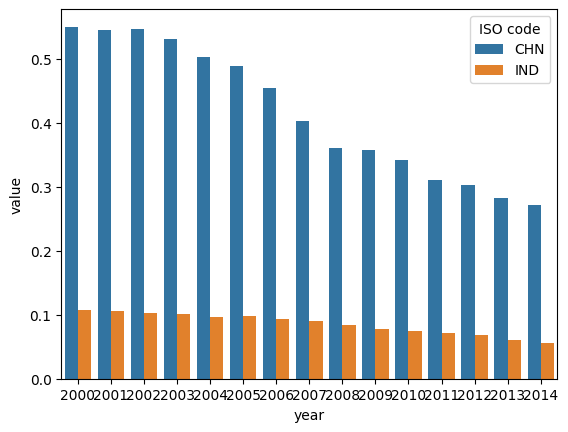

In [19]:
data_filter = PPP_exchage_filtered.loc[(PPP_exchage_filtered['ISO code'].isin(['IND','CHN']))]
sns.barplot(data=data_filter, x='year', y='value', hue='ISO code')

In [20]:
SEA.head()

,country,variable,code,year,value
0,AUS,CAP,A01,2000,9739.77
1,AUS,CAP,A02,2000,582.69
2,AUS,CAP,A03,2000,869.31
3,AUS,CAP,B,2000,28250.15
4,AUS,CAP,C10-C12,2000,6401.86


In [21]:
%%time

ind_ppps = []
for (country,year),dfx in tqdm(SEA.groupby(['country','year']), unit=' country'):
    X_ppp = PPP_exchage_filtered.loc[(PPP_exchage_filtered['year']==str(year)) & (PPP_exchage_filtered['ISO code']==country)]['value'].values[0]
    dfx['tot_ind_ppp'] = dfx['value']*X_ppp

    ind_ppps.append(dfx)

tot_ind_ppp_df = pd.concat(ind_ppps).reset_index()
tot_ind_ppp_df.head()

100%|██████████| 645/645 [00:00<00:00, 691.01 country/s]


CPU times: user 1.86 s, sys: 97.2 ms, total: 1.96 s
Wall time: 1.96 s


,index,country,variable,code,year,value,tot_ind_ppp
0,0,AUS,CAP,A01,2000,9739.77,10285.682219
1,1,AUS,CAP,A02,2000,582.69,615.349661
2,2,AUS,CAP,A03,2000,869.31,918.034657
3,3,AUS,CAP,B,2000,28250.15,29833.565426
4,4,AUS,CAP,C10-C12,2000,6401.86,6760.683011


<Axes: xlabel='year', ylabel='tot_ind_ppp'>

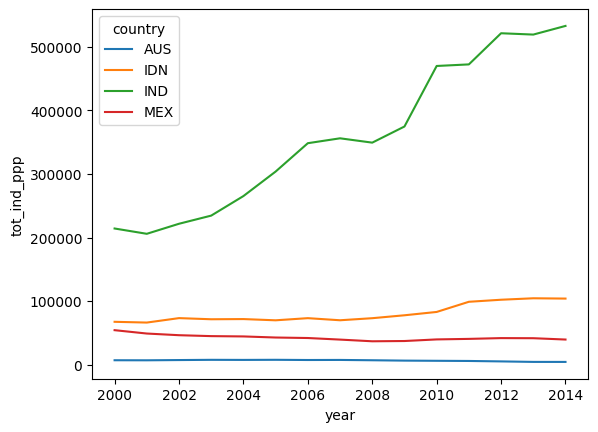

In [22]:
data_filter = tot_ind_ppp_df.loc[(tot_ind_ppp_df['country'].isin(['IND','AUS', 'IDN', "MEX"])) & (tot_ind_ppp_df['code']=='C13-C15') & (tot_ind_ppp_df['variable']=='GO')]
sns.lineplot(data=data_filter, x='year', y='tot_ind_ppp', hue='country')

In [23]:
tot_ind_ppp_df_GO = tot_ind_ppp_df[tot_ind_ppp_df['variable']=='GO']
tot_ind_ppp_df_GO = tot_ind_ppp_df_GO.groupby(['code','year']).sum().reset_index().drop(['country','value','variable','index'], axis=1)
tot_ind_ppp_df_GO.head()

,code,year,tot_ind_ppp
0,A01,2000,3.508316e+06
1,A01,2001,3.605992e+06
2,A01,2002,3.598810e+06
3,A01,2003,3.736123e+06
4,A01,2004,4.060107e+06


In [24]:
SEA_USD_x = pd.melt(SEA_USD, id_vars=['country', 'code', 'variable'], value_vars=year_range)
SEA_USD_x = SEA_USD_x.loc[SEA_USD_x['variable']=="GO"]
SEA_USD_x = SEA_USD_x.groupby(['code','year']).sum().reset_index().drop(['country','variable'], axis=1)

SEA_USD_x['SEA_by_PPP'] = SEA_USD_x['value']/tot_ind_ppp_df_GO['tot_ind_ppp']
SEA_USD_x.drop('value', axis=1, inplace=True)
print(SEA_USD_x.shape)
SEA_USD_x.head(5)

(840, 3)


,code,year,SEA_by_PPP
0,A01,2000,0.364607
1,A01,2001,0.354486
2,A01,2002,0.359874
3,A01,2003,0.394123
4,A01,2004,0.420667


In [25]:
PPP_exchage_filtered.head()

,ISO code,Country,year,value
8,AUS,Australia,2000,1.056050
9,AUT,Austria,2000,1.447184
12,BEL,Belgium,2000,1.421313
16,BGR,Bulgaria,2000,2.679952
24,BRA,Brazil,2000,1.352885


In [26]:
%%time
ind_ex_rates = []
for (country,year),dfx in tqdm(PPP_exchage_filtered.groupby(['Country','year']), unit=' country'):
    ppp_ex = dfx['value'].values[0]
    sea_by_ppp_x = SEA_USD_x[SEA_USD_x['year']==int(year)].copy()
    sea_by_ppp_x['country'] = dfx['ISO code'].values[0]
    sea_by_ppp_x['ind_ppp_ex'] = sea_by_ppp_x['SEA_by_PPP']*ppp_ex

    ind_ex_rates.append(sea_by_ppp_x)

ind_ex_rate = pd.concat(ind_ex_rates).reset_index(drop=True)
ind_ex_rate.head()

100%|██████████| 645/645 [00:01<00:00, 517.00 country/s]

CPU times: user 1.25 s, sys: 30.3 ms, total: 1.28 s
Wall time: 1.35 s


,code,year,SEA_by_PPP,country,ind_ppp_ex
0,A01,2000,0.364607,AUS,0.385043
1,A02,2000,0.389933,AUS,0.411789
2,A03,2000,0.353583,AUS,0.373401
3,B,2000,0.432509,AUS,0.456751
4,C10-C12,2000,0.516493,AUS,0.545442


### Country Industry PPP

In [27]:
SEA_GO = SEA[SEA['variable']=="GO"].drop('variable',axis=1).copy()
country_ind_ppp = pd.merge(
    left=SEA_GO,
    right=ind_ex_rate,
    left_on = SEA_GO['country']+SEA_GO['code']+SEA_GO['year'].astype(str),
    right_on =ind_ex_rate['country']+ind_ex_rate['code']+ind_ex_rate['year'].astype(str),
    suffixes=('', '_y'),
    how='inner'
)


country_ind_ppp['country_ind_ppp'] = country_ind_ppp['value']*country_ind_ppp['ind_ppp_ex']

country_ind_ppp = country_ind_ppp.drop(['key_0', 'code_y','year_y','SEA_by_PPP', 'country_y'], axis=1)
country_ind_ppp.dropna(inplace=True)
country_ind_ppp.sample(5)

,country,code,year,value,ind_ppp_ex,country_ind_ppp
30413,LUX,C13-C15,2012,589.600,0.423620,249.766521
27806,ITA,H49,2011,92152.400,0.961806,88632.686877
25686,LVA,J61,2010,786.700,1.675085,1317.789075
27581,HUN,G47,2011,1862817.000,0.006264,11668.103083
7588,CHE,G46,2003,79239.537,0.456665,36185.914194


### World Industry Value

In [28]:
GO_industry_total = SEA_GO.groupby(['code','year']).sum().reset_index().drop(columns=['country'],axis=1)
GO_industry_total = GO_industry_total.rename(columns = {'value':'GO'})

SEA_HEMPE = SEA[SEA['variable']=="H_EMPE"].copy().drop(columns=['country', 'variable'],axis=1)
HEMPE_industry_total = SEA_HEMPE.groupby(['code','year']).sum().reset_index()
HEMPE_industry_total = HEMPE_industry_total.rename(columns = {'value':'H_EMPE'})

HEMPE_GO_ind_total = HEMPE_industry_total.set_index(['code','year']).join(GO_industry_total.set_index(['code','year'])).reset_index()
HEMPE_GO_ind_total.sample(3)

,code,year,H_EMPE,GO
305,C30,2005,4822.6471,7.340240e+07
381,E37-E39,2006,3073.1870,1.168339e+07
602,K64,2002,24212.5518,1.979684e+08


In [29]:
%%time
world_industry_values = []
for country,dfx in tqdm(country_ind_ppp.groupby(['country']), unit=' country'):
    world_industry_value = pd.merge(
        left=dfx,
        right=HEMPE_GO_ind_total,
        left_on = dfx['code']+dfx['year'].astype(str),
        right_on =HEMPE_GO_ind_total['code']+HEMPE_GO_ind_total['year'].astype(str),
        suffixes=('', '_y'),
        how='inner'
    )

    world_industry_value = world_industry_value.drop(['key_0', 'code_y','year_y'], axis=1)

    world_industry_values.append(world_industry_value)

world_industry_values = pd.concat(world_industry_values).reset_index(drop=True)
world_industry_values.head()

100%|██████████| 43/43 [00:00<00:00, 155.74 country/s]


CPU times: user 282 ms, sys: 1.8 ms, total: 284 ms
Wall time: 302 ms


,country,code,year,value,ind_ppp_ex,country_ind_ppp,H_EMPE,GO
0,AUS,A01,2000,49709.210,0.385043,19140.186311,260801.8294,2.818576e+08
1,AUS,A02,2000,2586.232,0.411789,1064.981635,25176.0964,2.897634e+07
2,AUS,A03,2000,2597.053,0.373401,969.741863,12209.6857,3.470360e+07
3,AUS,B,2000,58406.047,0.456751,26677.002857,11952.2797,2.062574e+08
4,AUS,C10-C12,2000,58673.688,0.545442,32003.105786,38579.8683,4.026327e+08


### Calculate homogeneous Labour

In [30]:
world_industry_values['hom_labour'] = world_industry_values['country_ind_ppp']*world_industry_values['H_EMPE']/world_industry_values['GO']
world_industry_values.head()

,country,code,year,value,ind_ppp_ex,country_ind_ppp,H_EMPE,GO,hom_labour
0,AUS,A01,2000,49709.210,0.385043,19140.186311,260801.8294,2.818576e+08,17.710345
1,AUS,A02,2000,2586.232,0.411789,1064.981635,25176.0964,2.897634e+07,0.925310
2,AUS,A03,2000,2597.053,0.373401,969.741863,12209.6857,3.470360e+07,0.341182
3,AUS,B,2000,58406.047,0.456751,26677.002857,11952.2797,2.062574e+08,1.545888
4,AUS,C10-C12,2000,58673.688,0.545442,32003.105786,38579.8683,4.026327e+08,3.066506


In [31]:
world_industry_values.to_excel('world_industry_values.xlsx')

### Plotting Homogeneous Labour in $

<Axes: xlabel='year', ylabel='hom_labour'>

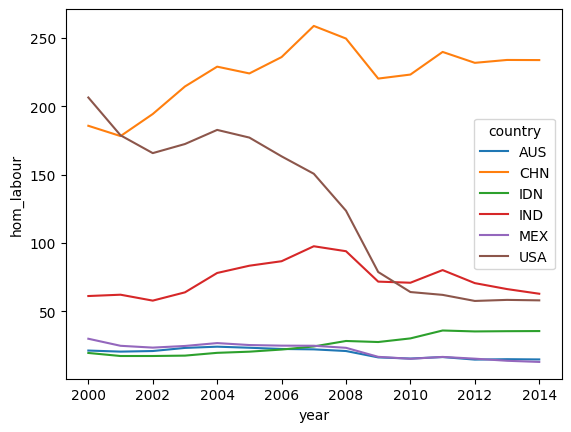

In [32]:
countries = ['IND','AUS', 'IDN', "MEX", "CHN", "USA"]
data_filter = world_industry_values.loc[(world_industry_values['country'].isin(countries)) & (world_industry_values['code']=='F')]
sns.lineplot(data=data_filter, x='year', y='hom_labour', hue='country')

In [33]:
world_industry_values.describe()

,value,ind_ppp_ex,country_ind_ppp,H_EMPE,GO,hom_labour
count,3.612000e+04,36120.000000,3.612000e+04,36120.000000,3.612000e+04,36120.000000
mean,5.619546e+06,0.685653,3.922423e+04,30689.717916,2.416405e+08,7.269695
std,5.325138e+07,0.527020,1.351723e+05,46082.054314,3.378267e+08,31.752405
min,0.000000e+00,0.000131,0.000000e+00,0.047000,5.333060e+02,0.000000
25%,1.330175e+03,0.110109,1.040668e+03,5377.553750,4.553640e+07,0.117451
50%,1.417800e+04,0.707232,5.738215e+03,13112.225500,1.357937e+08,0.716327
75%,9.733963e+04,1.057976,2.497810e+04,27806.747975,3.130893e+08,3.601492
max,3.027433e+09,3.629009,3.550996e+06,262589.921600,3.359589e+09,1218.587163


## International Market Value (MV)


In [34]:
SEA_USD_melt = pd.melt(SEA_USD, id_vars=['country','variable','code'], value_vars= year_range, var_name='year')
SEA_USD_GO_sum = SEA_USD_melt[['variable', 'value','year']][SEA_USD_melt['variable']=='GO'].groupby('year').sum().drop('variable', axis=1).reset_index()
SEA_HEMPE_sum = SEA[['variable', 'value','year']][SEA['variable']=='H_EMPE'].groupby('year').sum().drop('variable', axis=1).reset_index()

MEV = SEA_HEMPE_sum.copy().drop(['value'],axis=1)
MEV['MEV'] = SEA_USD_GO_sum['value']/SEA_HEMPE_sum['value']
MEV

,year,MEV
0,2000,35.672182
1,2001,35.106767
2,2002,36.289156
3,2003,40.565310
4,2004,44.970490
5,2005,48.518267
6,2006,51.818365
7,2007,57.581716
8,2008,63.241141
9,2009,59.048367


In [35]:
SEA_USD[SEA_USD['variable'].isin(['K','GO']) & SEA_USD['country'].isin(['AUS','IND','IDN']) & SEA_USD['code'].isin(['A01'])]

year,country,variable,code,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
224,AUS,GO,A01,28947.959607,30957.684782,25292.346147,34889.990730,39645.927147,42012.510005,36429.086769,46225.675125,50077.341148,45742.080250,59637.655072,69566.630072,71514.739400,71459.259903,70292.034587
616,AUS,K,A01,39799.823577,36621.912053,39886.941034,51153.411795,62475.631242,69397.728989,74810.750515,89284.205980,95409.814050,89407.729743,105799.862882,121320.090125,125052.330802,117797.242582,112960.598377
18144,IDN,GO,A01,26971.930614,25978.475942,32278.221116,37957.120563,38814.652384,39611.879177,48107.168776,58850.741114,72528.226851,78402.845333,101622.948793,116266.943957,117716.880941,117162.620089,112492.713475
18536,IDN,K,A01,16485.304380,15055.093134,17338.851907,20624.442909,22571.328982,24128.696928,30555.346030,35150.640028,41541.671734,49670.246555,64298.781250,73679.169033,75924.637625,73993.512164,73186.723423
19040,IND,GO,A01,119836.589230,124203.712177,118370.122574,139227.773247,148234.818901,171203.461777,187717.798071,234165.135845,252618.261511,259166.931408,330669.957272,366814.957198,356133.418999,369830.454361,369345.847310
19432,IND,K,A01,144783.369345,150529.383671,155776.699764,177687.930507,204865.721118,225550.763288,241886.573458,294734.657913,319021.854878,316632.345067,373975.773299,418691.262178,432533.549308,466389.238891,474219.622470


In [36]:
SEA_USD_GO = SEA_USD_melt[SEA_USD_melt['variable']=='GO'].reset_index(drop=True)

SEA_USD_K = SEA_USD_melt[SEA_USD_melt['variable']=='K'].reset_index(drop=True)
SEA_USD_K.head()

,country,variable,code,year,value
0,AUS,K,A01,2000,39799.823577
1,AUS,K,A02,2000,1507.755523
2,AUS,K,A03,2000,2689.243546
3,AUS,K,B,2000,84688.831742
4,AUS,K,C10-C12,2000,12159.831139


### Calculate market price

In [37]:
WIV_x = world_industry_values[['country', 'code', 'year', 'hom_labour']].copy()
WIV_x

,country,code,year,hom_labour
0,AUS,A01,2000,17.710345
1,AUS,A02,2000,0.925310
2,AUS,A03,2000,0.341182
3,AUS,B,2000,1.545888
4,AUS,C10-C12,2000,3.066506
...,...,...,...,...
36115,USA,P85,2014,51.614154
36116,USA,Q,2014,560.397987
36117,USA,R_S,2014,85.154775
36118,USA,T,2014,90.079776


In [38]:
MVs=[]
for year, dfx in tqdm(WIV_x.groupby('year'), unit=' Year'):
    dfx['MEVLH'] = MEV.loc[MEV['year']==year,'MEV'].iloc[0]*dfx['hom_labour']
    MVs.append(dfx)

MV_data = pd.concat(MVs)
MV_data['K'] = SEA_USD_K['value']
MV_data['GO'] = SEA_USD_GO['value']
MV_data['MP'] = MV_data['K']+MV_data['GO']
MV_data['MV'] = MV_data['MEVLH']+MV_data['K']
MV_data['diff'] = MV_data['MP']-MV_data['MV']
MV_data.head(5)

100%|██████████| 15/15 [00:00<00:00, 813.18 Year/s]


,country,code,year,hom_labour,MEVLH,K,GO,MP,MV,diff
0,AUS,A01,2000,17.710345,631.766632,39799.823577,28947.959607,68747.783184,40431.590210,28316.192974
1,AUS,A02,2000,0.925310,33.007809,1507.755523,1506.081860,3013.837383,1540.763332,1473.074051
2,AUS,A03,2000,0.341182,12.170706,2689.243546,1512.383426,4201.626972,2701.414252,1500.212720
3,AUS,B,2000,1.545888,55.145213,84688.831742,34012.527846,118701.359588,84743.976955,33957.382633
4,AUS,C10-C12,2000,3.066506,109.388950,12159.831139,34168.387512,46328.218651,12269.220089,34058.998562


<Axes: xlabel='year', ylabel='diff'>

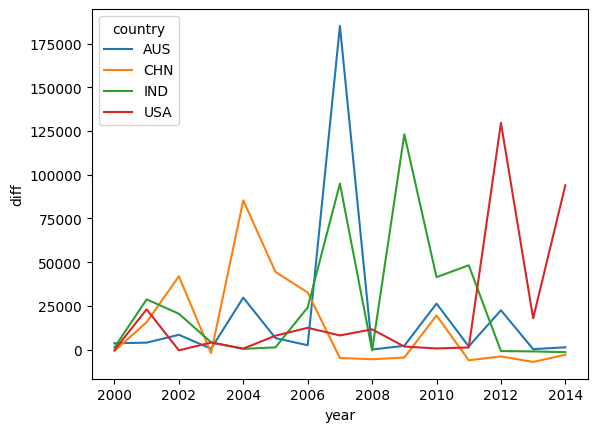

In [39]:
countries = ['IND','USA','AUS','CHN']
data_filter = MV_data.loc[(MV_data['country'].isin(countries)) & (MV_data['code']=='C13-C15')].copy()
sns.lineplot(data=data_filter, x='year', y='diff', hue='country')

In [40]:
MV_data['diff'].describe()

count    3.612000e+04
mean     3.883688e+04
std      1.320221e+05
min     -4.375939e+04
25%      7.823323e+02
50%      5.696780e+03
75%      2.600858e+04
max      3.403617e+06
Name: diff, dtype: float64

(-43759.39, 43759.39)

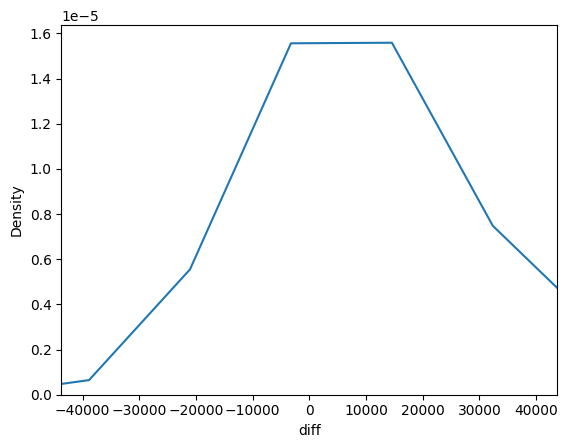

In [43]:
ax = sns.kdeplot(data=MV_data, x='diff')
ax.set_xlim(-4.375939e+04, 4.375939e+04)

## World Input Output Analysis

In [47]:
%%time

with ZipFile("wiot.zip", 'r') as zObject:
    zObject.extractall()

In [48]:
%%time
df = pd.read_excel('WIOT2000_Nov16_ROW.xlsb', engine='pyxlsb')

CPU times: user 1min 6s, sys: 1.4 s, total: 1min 7s
Wall time: 1min 10s


In [60]:
df.head(10)

,Intercountry Input-Output Table,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 2679,Unnamed: 2680,Unnamed: 2681,Unnamed: 2682,Unnamed: 2683,Unnamed: 2684,Unnamed: 2685,Unnamed: 2686,Unnamed: 2687,Unnamed: 2688
0,"43 countries, in current prices",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,(industry-by-industry),NaN,NaN,NaN,A01,A02,A03,B,C10-C12,C13-C15,...,CONS_np,CONS_g,GFCF,INVEN,CONS_h,CONS_np,CONS_g,GFCF,INVEN,GO
2,(millions of US$),NaN,NaN,NaN,"Crop and animal production, hunting and relate...",Forestry and logging,Fishing and aquaculture,Mining and quarrying,"Manufacture of food products, beverages and to...","Manufacture of textiles, wearing apparel and l...",...,Final consumption expenditure by non-profit or...,Final consumption expenditure by government,Gross fixed capital formation,Changes in inventories and valuables,Final consumption expenditure by households,Final consumption expenditure by non-profit or...,Final consumption expenditure by government,Gross fixed capital formation,Changes in inventories and valuables,Total output
3,NaN,NaN,NaN,NaN,AUS,AUS,AUS,AUS,AUS,AUS,...,USA,USA,USA,USA,ROW,ROW,ROW,ROW,ROW,TOT
4,NaN,NaN,NaN,NaN,c1,c2,c3,c4,c5,c6,...,c58,c59,c60,c61,c57,c58,c59,c60,c61,c62
5,A01,"Crop and animal production, hunting and relate...",AUS,r1,5876.833181,187.067919,65.079122,24.45264,9979.470649,249.425583,...,0,0,0.603338,0.031894,336.975473,0.000317,4.333551,8.914831,-0.000221,28947.959651
6,A02,Forestry and logging,AUS,r2,78.053348,41.448143,0.946121,3.572607,0.780698,0.097985,...,0,0,0.000202,0.000011,0.271302,0.000001,0.000018,0.086613,-0.000181,1506.081601
7,A03,Fishing and aquaculture,AUS,r3,10.916019,0.01848,8.363733,0.623371,254.706044,19.667171,...,0,0,0.000118,0.018981,163.504977,0.000126,0.001033,0.2445,0.000071,1512.383198
8,B,Mining and quarrying,AUS,r4,14.206129,0.243553,0.211697,996.265557,38.892554,2.423638,...,0,0,45.231545,0.003082,12.060419,0.000082,0.069017,16.497247,-0.038965,34012.527629
9,C10-C12,"Manufacture of food products, beverages and to...",AUS,r5,820.496849,7.001094,45.912387,45.81985,4809.581899,159.040816,...,0,0,1.962467,0.099112,1793.83206,0.000762,9.407714,0.923524,-0.000129,34168.387578


Create a condensed table with:
- c1-cN - columns
- r1-rN - rows

In [54]:
industries = df.iloc[5:-8, :3].reset_index(drop=True).copy()
industries.columns = ['code', 'industry', 'country']
print('Total number of industries',industries.shape[0])
industries

Total number of industries 2464


,code,industry,country
0,A01,"Crop and animal production, hunting and relate...",AUS
1,A02,Forestry and logging,AUS
2,A03,Fishing and aquaculture,AUS
3,B,Mining and quarrying,AUS
4,C10-C12,"Manufacture of food products, beverages and to...",AUS
...,...,...,...
2459,P85,Education,ROW
2460,Q,Human health and social work activities,ROW
2461,R_S,Other service activities,ROW
2462,T,Activities of households as employers; undiffe...,ROW


In [62]:
industries['code']

0           A01
1           A02
2           A03
3             B
4       C10-C12
         ...   
2459        P85
2460          Q
2461        R_S
2462          T
2463          U
Name: code, Length: 2464, dtype: object

In [63]:
value.shape

(2472, 2465)

In [64]:
value = df.iloc[5:, 4:industries.shape[0]+4].copy()
value.columns = industries['code']
value['industry'] = industries['code']
# value['country'] = industries['country']
value.head(5)

ValueError: Length mismatch: Expected axis has 2460 elements, new values have 2464 elements

In [ ]:
# isProductive = ['K64', 'K65', 'K66', 'L68', 'M69_M70', 'N', 'O84', 'T', 'U']

# value[value['industry'].isin(isProductive)].groupby('country').sum().iloc[:,:-1].sum(axis=1)